# Lab 1: Gaussian Process Regression
### Gaussian Process Summer School 2018
_written by Wil Ward, adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/)_


This lab is designed to introduce Gaussian processes in a practical way, illustrating the concepts introduced in the first two lectures. The key aspects of Gaussian process regression are covered: the covariance function (aka kernels); sampling a Gaussian process; and the regression model. The notebook will introduce the Python library `GPy`$^\dagger$ which handles the kernels, regression and optimisation of hyperparameter, allowing us to easily access the results we want.

The level of this notebook is aimed at introductory, as the background of attendees is diverse, and so cover a wide range of basic GP concepts. There are seven exercises to complete, the difficulty of which varies, but you should aim to complete all during the lab session. The notebook will not be marked and we will provide answers to the exercises after the lab session.

In addition, there is a second _optional_ notebook with extra work. The content of this is more advanced, so completion is at your discretion.

$^\dagger$`GPy`: A Gaussian process framework in Python (since 2012). Available from http://github.com/SheffieldML/GPy

## 1. Getting started

Make sure that `GPy` is already installed on your machine. You should be using Python 3.5 (or above). A set of instructions for setting up your environment are [available from the GPSS site](http://gpss.cc/gpss18/getting_started).

First, we need to setup our notebook with the libraries we are going to use. We will use `numpy` for maths functionality, `pyplot` for plotting, and of course `GPy` for Gaussian processes.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

### Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPy`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, we define our kernels using the input dimension as the first argument, in the simplest case `input_dim=1` for 1-dimensional regression. We can also explicitly define the parameters, but for now we will use the default values:

In [2]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


We can see from the above table that our kernel has two parameters, `variance` and `lengthscale`, both with value `1.0`. There is also information on the constraints and priors on each parameter, but we will look at this later.

### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ with samples $x = x'$. The resulting GP prior is a multivariate normal distribution over the space of samples $x$: $\mathcal{N}(\mathbf{0}, \mathbf{K}_{xx})$. It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2[=1]$ in the diagonal.

We can show this using `pyplot` to plot the vector $k(x,0)$ and the matrix $k(x,x')$ using `k.K(`$\cdot$ `,` $\cdot$`)`:

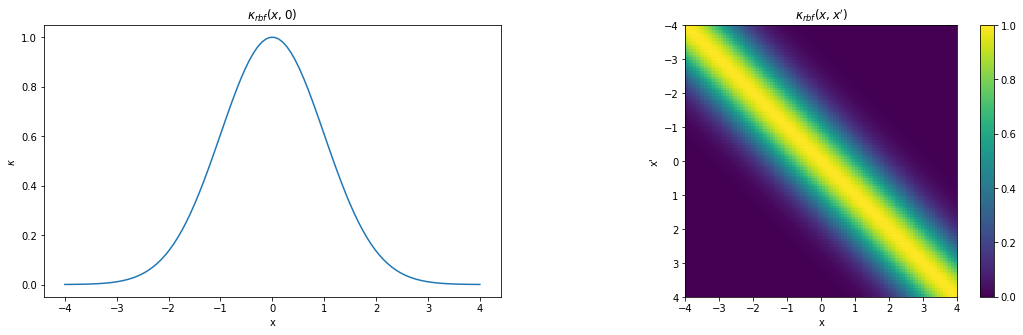

In [3]:
# Our sample space: 100 samples in the interval [-4,4]
X = np.linspace(-4.,4.,100)[:, None] # we need [:, None] to reshape X into a column vector for use in GPy

# Set up the plotting environment
plt.figure(figsize=(18,5))

# ==== k(x,0)

plt.subplot(121) # left plot

# First, sample kernel at x' = 0
K = k.K(X, np.array([[0.]])) # k(x,0)

# Plot covariance vector
plt.plot(X,K)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# ==== k(x,x')

plt.subplot(122) # right plot

# The kernel takes two inputs, and outputs the covariance between each respective point in the two inputs
K = k.K(X,X)

# Plot the covariance of the sample space
plt.pcolor(X.T, X, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

## Setting the kernel parameters

Looking at the above definition of the RBF kernel, we can see that the parameters, i.e. variance and lengthscale, control the shape of the covariance function and therefore the value of the covariance between points $x$ and $x'$.

We can access the value of the kernel parameters in `GPy` and manually set them by calling `k.param_name`, e.g. `k.lengthscale` or `k.variance` for the RBF kernel. The following example demonstrates how the value of the lengthscale affects the RBF kernel:

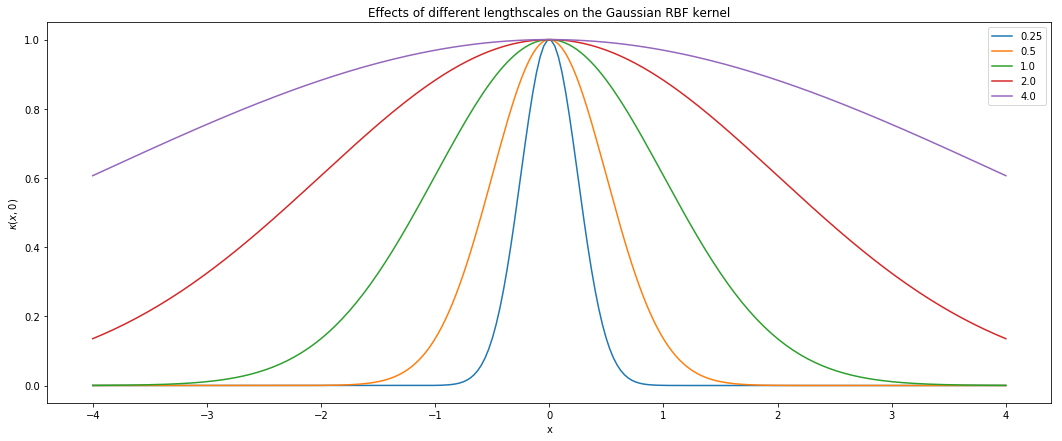

In [4]:
# Our sample space : 100 samples in the interval [-4,4] 
X = np.linspace(-4.,4.,250)[:, None] # we use more samples to get a smoother plot at low lengthscales

# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)

# Set up the plotting environment
plt.figure(figsize=(18, 7))

# Set up our list of different lengthscales
ls = [0.25, 0.5, 1., 2., 4.]

# Loop over the lengthscale values
for l in ls:
    # Set the lengthscale to be l
    k.lengthscale = l
    # Calculate the new covariance function at k(x,0)
    C = k.K(X, np.array([[0.]]))
    # Plot the resulting covariance vector
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa(x,0)$") 
plt.title("Effects of different lengthscales on the Gaussian RBF kernel")
plt.legend(labels=ls);

### Exercise 1

(a) What is the effect of the lengthscale parameter on the covariance function?

> _It causes the covariances to be higher between more distant locations in the input domain, i.e. nearby samples from the corresponding Gaussian process will be more likely to be similar as the lengthscale increased._

(b) Change the code used above to plot the covariance function showing the effects of the variance on the length scale. Comment on the effect.

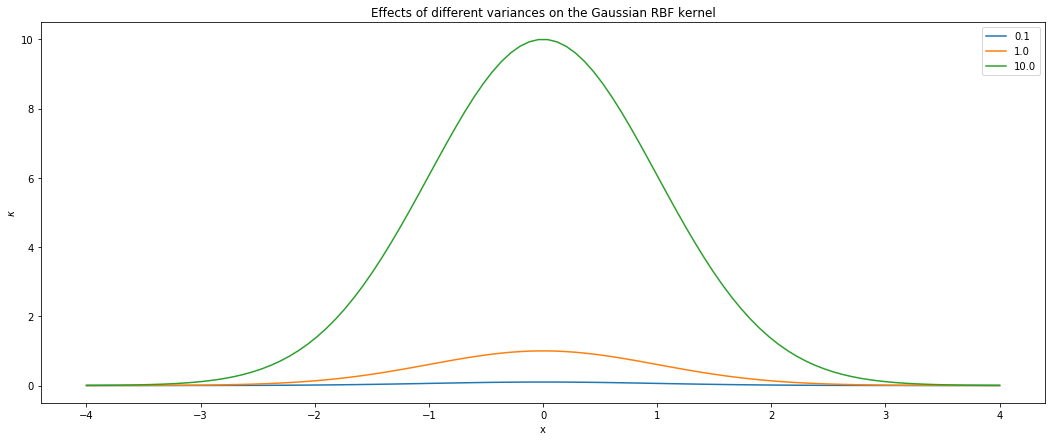

In [5]:
X = np.linspace(-4.,4.,100)[:, None]

k = GPy.kern.RBF(1)

# List of variances
vs = [0.1, 1., 10.]

plt.figure(figsize=(18, 7))

for v in vs:
    # Set the variance parameter of the kernel
    k.variance = v
    C = k.K(X, np.array([[0.]]))
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.title("Effects of different variances on the Gaussian RBF kernel")
plt.legend(labels=vs);

> _Increasing the variance parameter increases the covariance proportionally between all points, allowing for modelling of data with different variance._

---

## 2. Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Exponential`
- `Matern32`
- `Matern52`
- `Brownian`
- `Bias`
- `Linear`
- `StdPeriodic`
- `Cosine`
- `PeriodicMatern32`, 

Note: when defining these, all are preceded by `GPy.kern.` The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

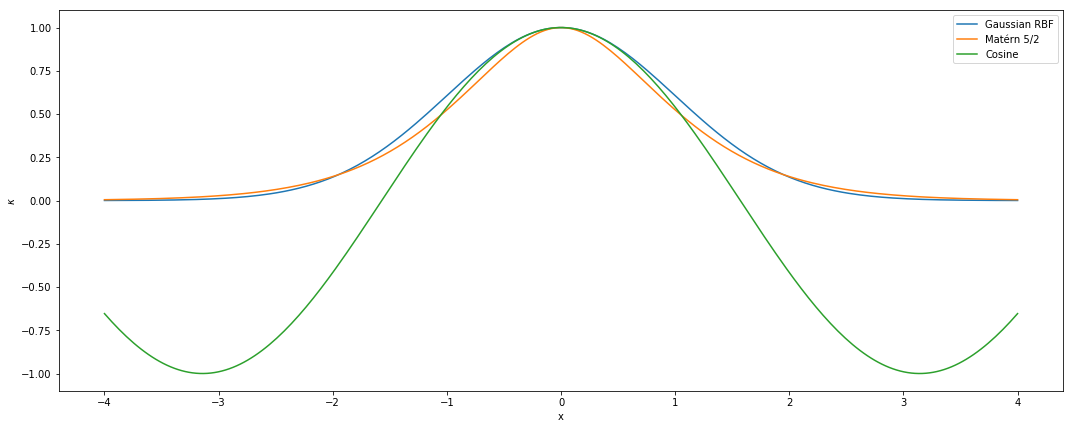

In [6]:
# Our sample space : 100 samples in the interval [-4,4] 
X = np.linspace(-4.,4.,250)[:, None]

# RBF kernel
k_R = GPy.kern.RBF(1)
C_R = k_R.K(X, np.array([[0.]]))

# Matern 5/2
k_M = GPy.kern.Matern52(1)
C_M = k_M.K(X, np.array([[0.]]))

# Cosine 
k_C = GPy.kern.Cosine(1)
C_C = k_C.K(X, np.array([[0.]]))

plt.figure(figsize=(18,7))
plt.plot(X, C_R, X, C_M, X, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

Not every kernel has the same set of parameters. Some kernels are not parameterised by a lengthscale, for example, like the `Linear` kernel which only has a list of variances corresponding to each linear component

In [7]:
GPy.kern.Linear(1)

linear.,value,constraints,priors
variances,1.0,+ve,


Likewise, not every kernel is stationary. In the case of the Gaussian RBF, or Matérn kernels, the kernel can be written $\kappa(x,x') = f(x-x')$, however this is not true for, e.g., the Brownian motion covariance function, which is defined as $k(x,x') = \min(x,x')$

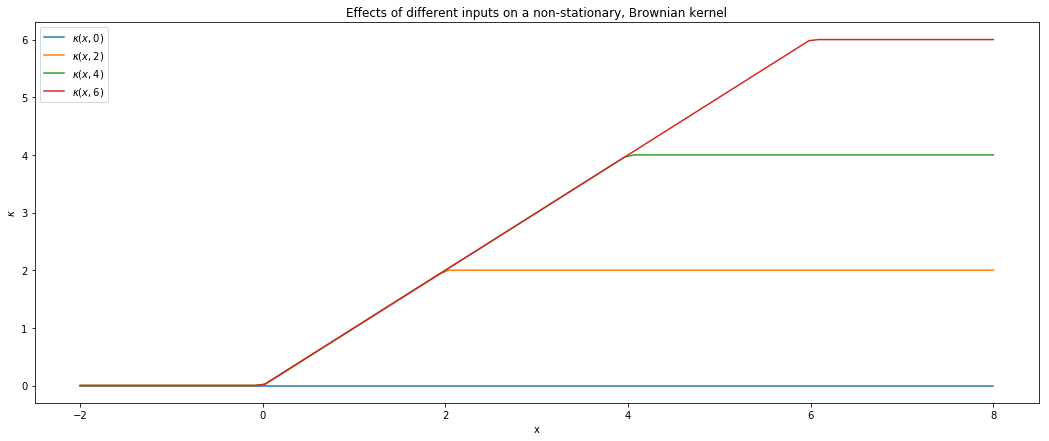

In [8]:
# Our sample space : 100 samples in the interval [-2,8] 
X = np.linspace(-2., 8., 100)[:,None]

# Note that the Brownian kernel is defined:
#   k = min(abs(x),abs(x')) if sgn(x) = sgn(x')
#   k = 0 if sgn(x) ≠ sgn(x')

# We define our Brownian kernel
k_B = GPy.kern.Brownian(1)

plt.figure(figsize=(18,7))

x_s = [0., 2., 4., 6.] # values of x'
# Loop through values of x'
for x_ in x_s:
    # Evaluate kernel at k(x,x')
    K_B = k_B.K(X, np.array([[x_]])) 
    # Plot covariance vector
    plt.plot(X, K_B)
    
# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("Effects of different inputs on a non-stationary, Brownian kernel")
plt.legend(labels=["$\kappa(x,0)$", "$\kappa(x,2)$", "$\kappa(x,4)$", "$\kappa(x,6)$"]);

---

## 3. Combining covariance functions

### Exercise 2

(a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product is greater than or equal to zero, $\mathbf{x}^\text{T}\mathbf{K}\mathbf{x} \geq 0$, _regardless of the values in $\mathbf{x}$_. Given this, it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective?

> _Thinking about the sum of two kernels in terms of the sum of two normal distributions. If we consider two **independent** kernels, $k_1$ and $k_2$, and corresponding covariance matrices over some (joint) sample space: $\mathbf{A} = k_2(\mathbf{x},\mathbf{x}^\text{T})$ and $\mathbf{B} = k_2(\mathbf{x},\mathbf{x}^\text{T})$, then the sum of two corresponding normal distributions with zero mean and covariance defined by the respective matrices, $\mathcal{N}(0, \mathbf{A}) + \mathcal{N}(0, \mathbf{B}) = \mathcal{N}(0, \mathbf{A}+\mathbf{B})$. From this we can infer that since the RHS of the equality is a valid distribution, $\mathbf{A}+\mathbf{B}$ must be postive semi-definite, and so $(x,x') \mapsto k_1(x,x') + k_2(x,x')$ results in positive semi-definite matrices regardless of $x$ and $x'$._
>
> _The equality holds only when $k_1$ and $k_2$ (and therefore $\mathbf{A}$ and $\mathbf{B}$) are **independent** . From a modelling perspective, this means we can use summative covariance functions to describe different, independent features in the modelled system. For example, we might want to separate some seasonality from an overall increasing trend. The sum of two kernels would allow use to do that. This is the motivation used in Section 7, using the Mauna Loa example._

(b) What about the element-wise product of two covariance functions? If we define $k(\mathbf{x}, \mathbf{x}') = k_1(\mathbf{x},\mathbf{x}')k_2(\mathbf{x},\mathbf{x}')$, then is $k(\mathbf{x},\mathbf{x}')$ a valid covariance function?

> _Again, by considering the two covariance matrices $\mathbf{A}$ and $\mathbf{B}$ obtained respectively from $k_1$ and $k_2$. Consider the case where $\mathbf{A}$ is symmetric. Since $\mathbf{A}$ is also semi-positive definite, it has symmetric semi-positive definite root $\mathbf{A}^{1/2}\mathbf{A}^{1/2} = \mathbf{A}$. The product $\mathbf{A}\mathbf{B}$ can be written $\mathbf{A}^{1/2}\mathbf{B}\mathbf{A}^{1/2}$, and $\mathbf{x}^T\mathbf{A}^{1/2}\mathbf{B}\mathbf{A}^{1/2}\mathbf{x} = (\mathbf{A}^{1/2}\mathbf{x})^\text{T}\mathbf{B}(\mathbf{A}^{1/2}\mathbf{x})$ due to the symmetry of $\mathbf{A}^{1/2}$, which in turn is greater than or equal to 0 due to the semi-positive definiteness of $\mathbf{B}$. Therefore, the product $\mathbf{AB}$ is also semi-positive definite._
>
>_In terms of modelling, this is less interpretable than in the additive case. In multidimensional input regression, for example, the product of kernels defined over different input variables can be used to combine information. The product of kernels might be considered similar to an AND operator, since the value of the kernel product will have high value if and only if the consitutient kernels both have high values. When modelling a stochastic process that is the product of two Gaussian process, the modelled function in general will not be Gaussian, but the Gaussian process with the covariance of products of the individual GP kernels exists._

### Combining kernels in GPy

We can easily combine kernels using `GPy` using the `+` and `*` operators, respectively denoting addition and product of kernels.

#### Summing kernels
An example of adding kernels is shown here. We create a new kernel that is the `sum` of an RBF and a Matern 5/2 kernel.

In [9]:
# Create the first kernel: a 1-D RBF with lengthscale 2.0
k_R = GPy.kern.RBF(1, lengthscale=2., name="RBF")
# Create the second kernel: a 1-D Matern52 with variance 2.0 and lengthscale 4.0
k_M = GPy.kern.Matern52(1, variance=2., lengthscale=4., name="Matern52")

# Add the kernels together
k_sum = k_R + k_M
# Preview the properties of the composite kernel
k_sum

sum.,value,constraints,priors
RBF.variance,1.0,+ve,
RBF.lengthscale,2.0,+ve,
Matern52.variance,2.0,+ve,
Matern52.lengthscale,4.0,+ve,


We can visualise our kernel sum to see the resulting effect. It should be fairly clear that the result is simply the sum of evaluations of the respective kernels for each sample point.

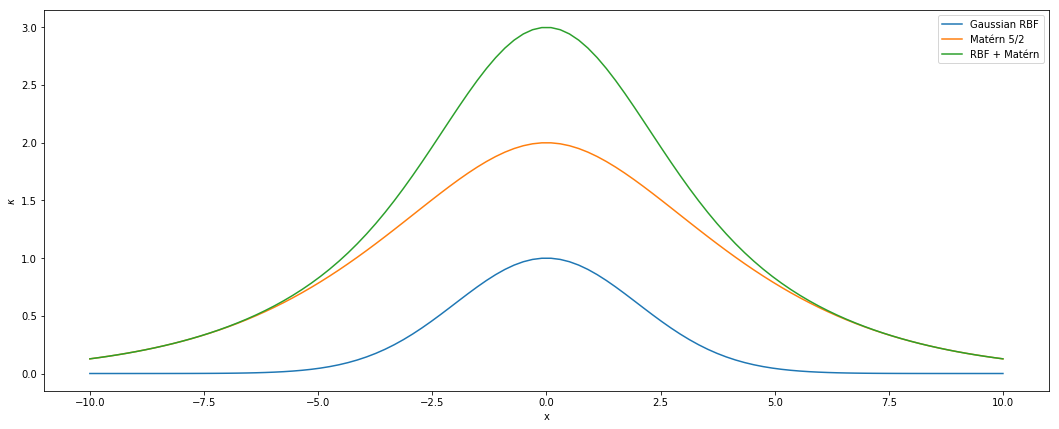

In [10]:
# Our sample space : 100 samples in the interval [-10,10] 
X = np.linspace(-10., 10., 100)[:,None]

# Set up the plotting environment
plt.figure(figsize=(18,7))

# Here we sample from the consituent and composite kernels
K_R   = k_R.K(X, np.array([[0.]]))    # RBF
K_M   = k_M.K(X, np.array([[0.]]))    # Matern 5/2
K_sum = k_sum.K(X, np.array([[0.]]))  # RBF + Matern

# Plot each of our covariance vectors
plt.plot(X, K_R, X, K_M, X, K_sum)
    
# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "RBF + Matérn"]);

#### Multiplying two kernels

We also demonstrate here the effect of multiplying two kernels. Here, we multiply an RBF and Periodic kernel, effectively encapsulating the periodicity into an RBF window:

In [11]:
# Create the first kernel: a 1-D RBF with lengthscale 5.0
k_R = GPy.kern.RBF(1, lengthscale=5., name="RBF")
# Create the second kernel: a 1-D StdPeriodic with period 5.0
k_P = GPy.kern.StdPeriodic(1, period=5., name="Periodic")

# Multiply the kernels together
k_mul = k_R * k_P

# Preview the properties of the composite kernel
k_mul

mul.,value,constraints,priors
RBF.variance,1.0,+ve,
RBF.lengthscale,5.0,+ve,
Periodic.variance,1.0,+ve,
Periodic.period,5.0,+ve,
Periodic.lengthscale,1.0,+ve,


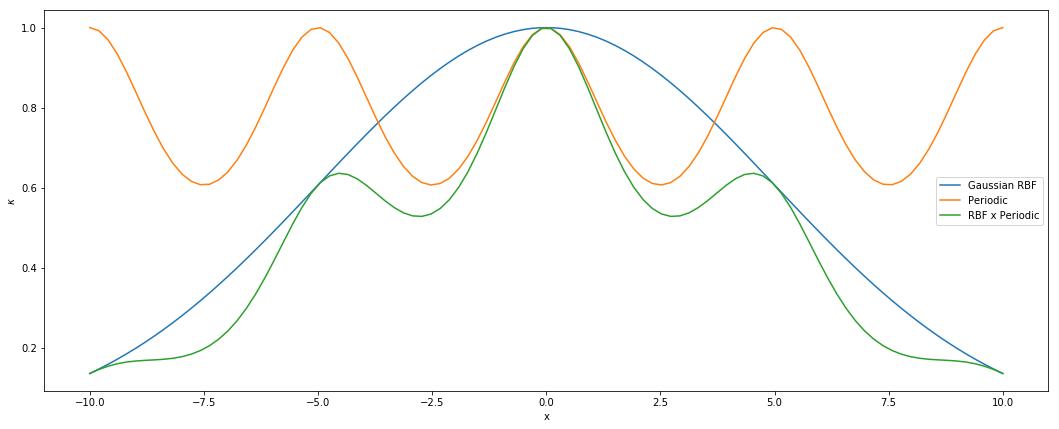

In [12]:
# Our sample space : 100 samples in the interval [-10,10] 
X = np.linspace(-10., 10., 100)[:,None]

# Set up the plotting environment
plt.figure(figsize=(18,7))

# Here we sample from the consituent and composite kernels
K_R   = k_R.K(X, np.array([[0.]]))      # RBF
K_P   = k_P.K(X, np.array([[0.]]))      # StdPeriodic
K_mul = k_mul.K(X, np.array([[0.]]))    # RBF * StdPeriodic

# Plot each of our covariance vectors
plt.plot(X, K_R, X, K_P, X, K_mul)
    
# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Periodic", "RBF x Periodic"]);

---

## 4. Sampling from a Gaussian Process

A Gaussian process provides a prior over some infinite-dimensional function, defined by a mean function and covariance function

$$ f(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

When we sample from the covariance function, $k$, to create a matrix over some sample space, we are creating a matrix of values that describe the covariance between sample points. Since it is not possible to sample every single point in an infinite dimensional function, we have to sample a finite subset of the input domain. Let $\mathbf{X}$ denote some sample inputs, and $\mathbf{K}$ the covariance matrix, with elements $K_{ij} = k(\mathbf{X}_i,\mathbf{X}_j)$, then we can describe the prior over $f(\mathbf{X})$ as a (finite-dimensional) normal distribution with covariance $\mathbf{K}$. As such, we can easily create samples of $f$ which, for a good choice of $\mathbf{X}$, are representative of the true function.

We can also sample from the kernel prior by creating a covariance matrix over a sample space and sampling from a zero-mean multivariate normal distribution with covariance $\mathbf{K}$. Below are examples of different kernels with different parameters, including composite kernels.

The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix


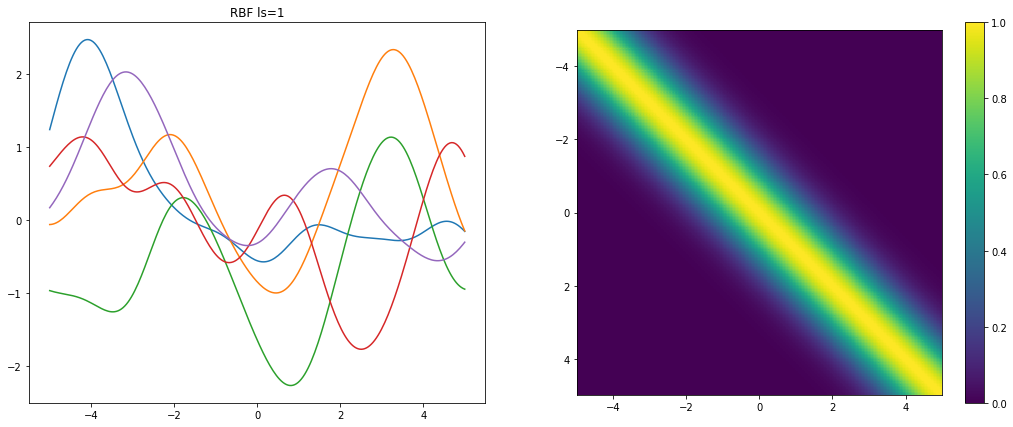

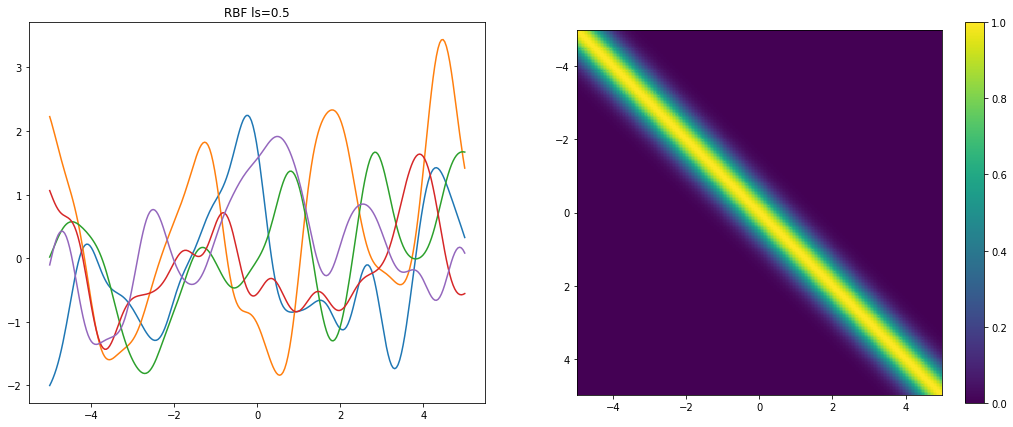

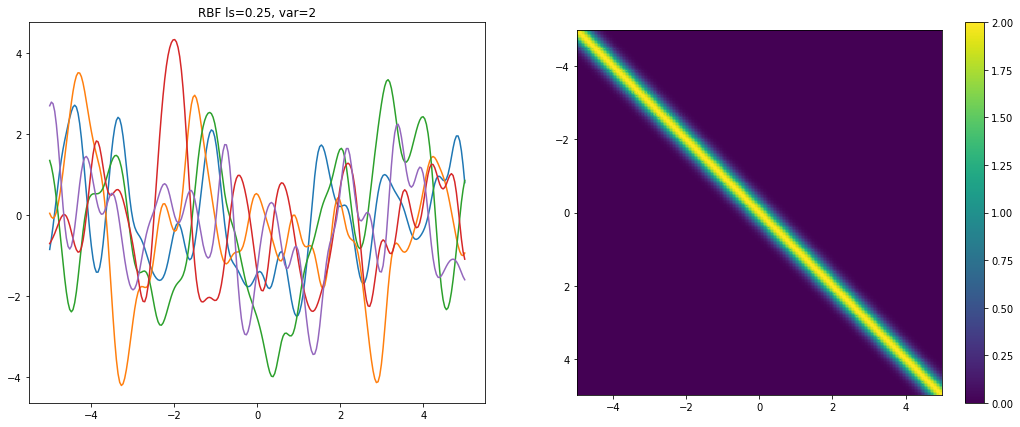

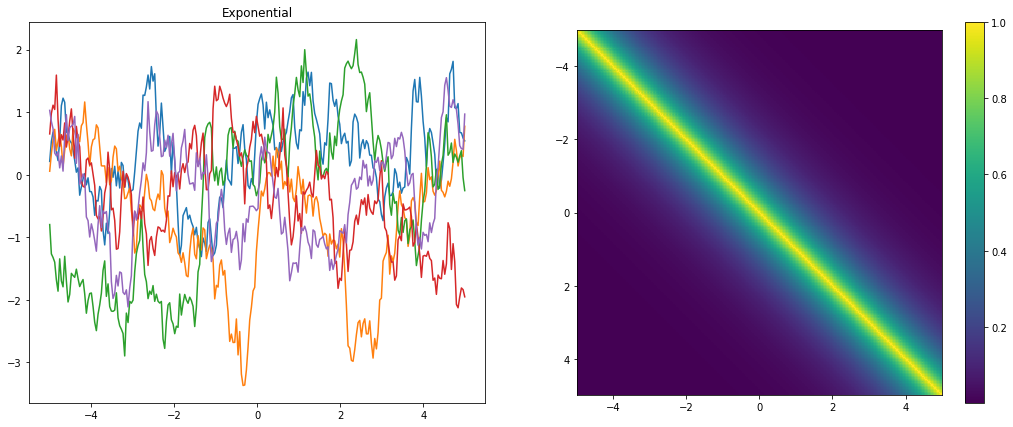

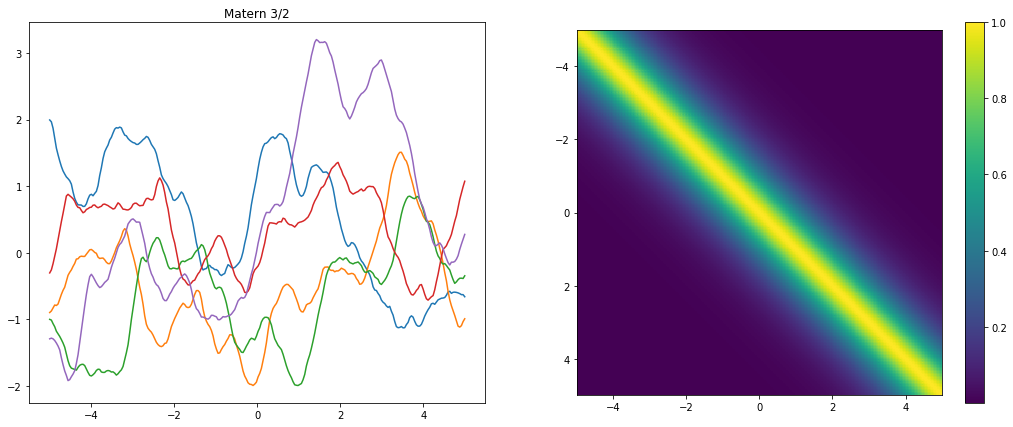

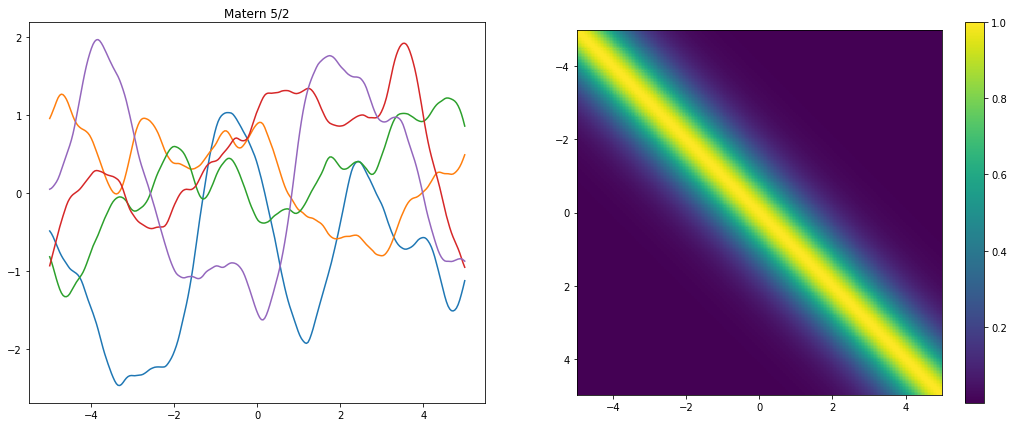

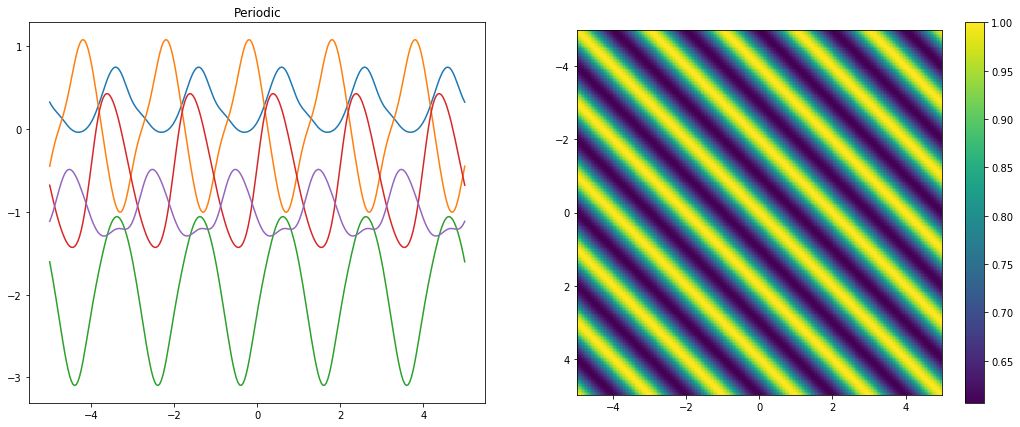

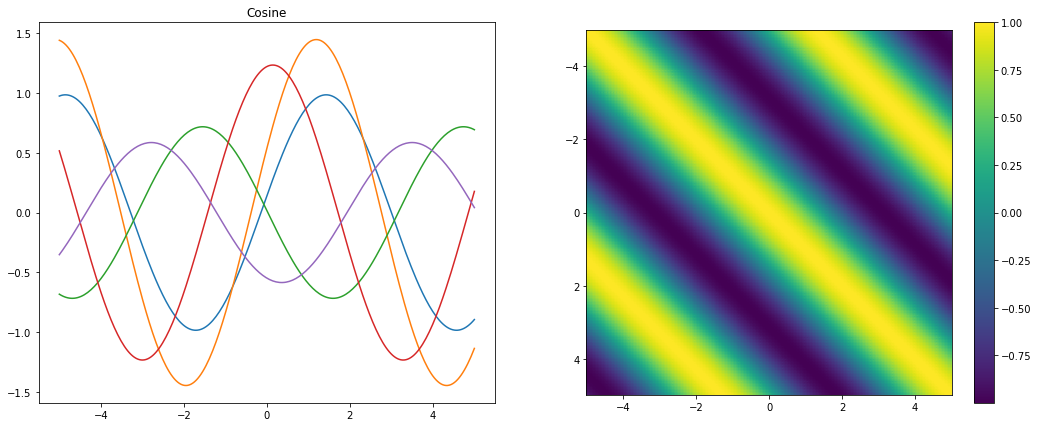

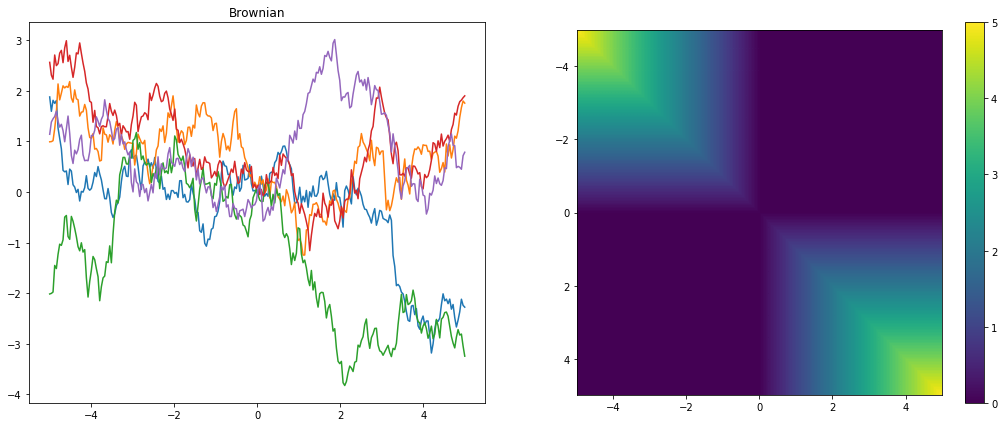

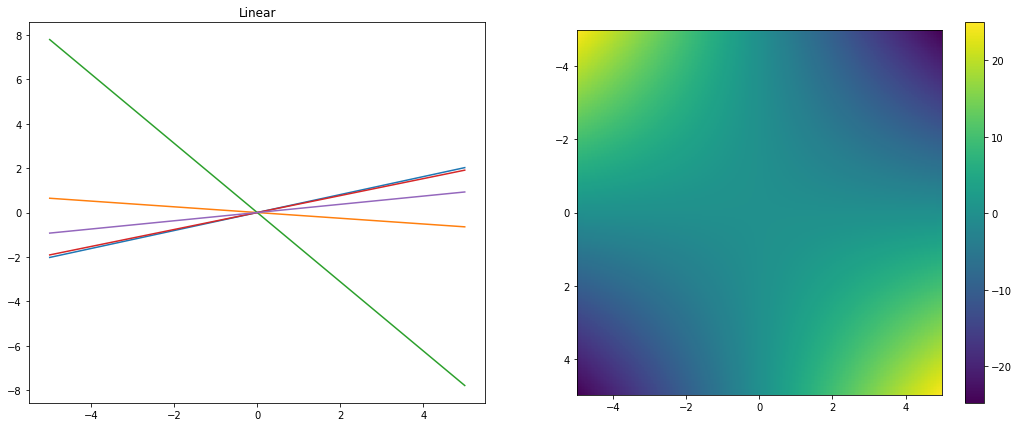

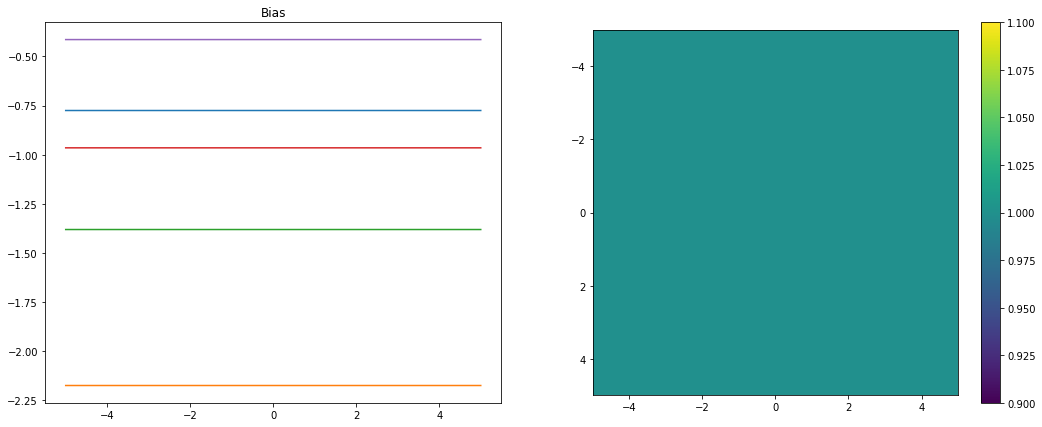

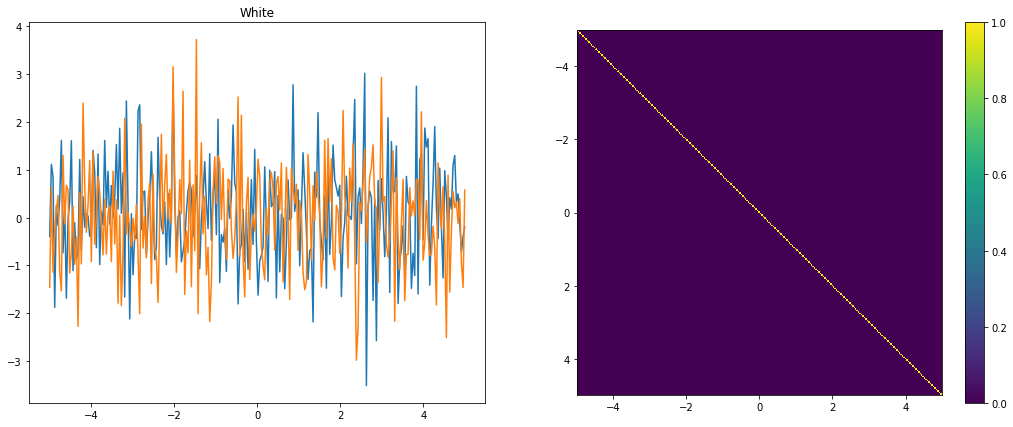

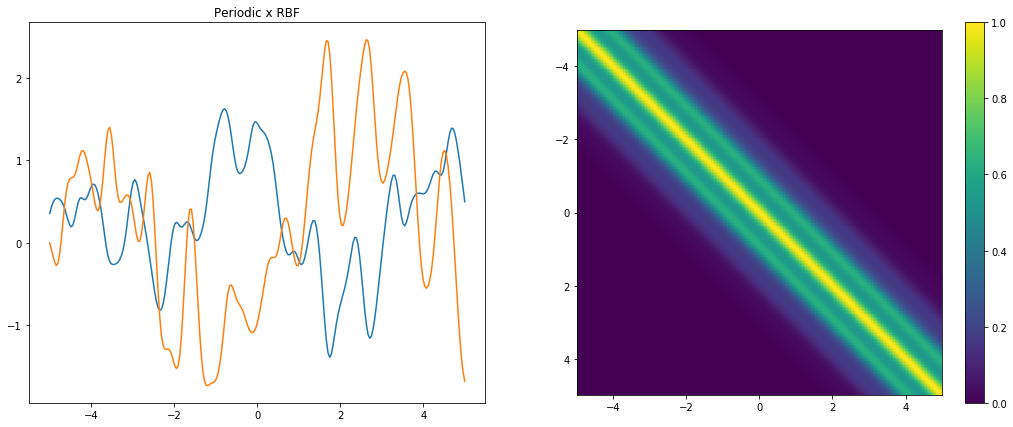

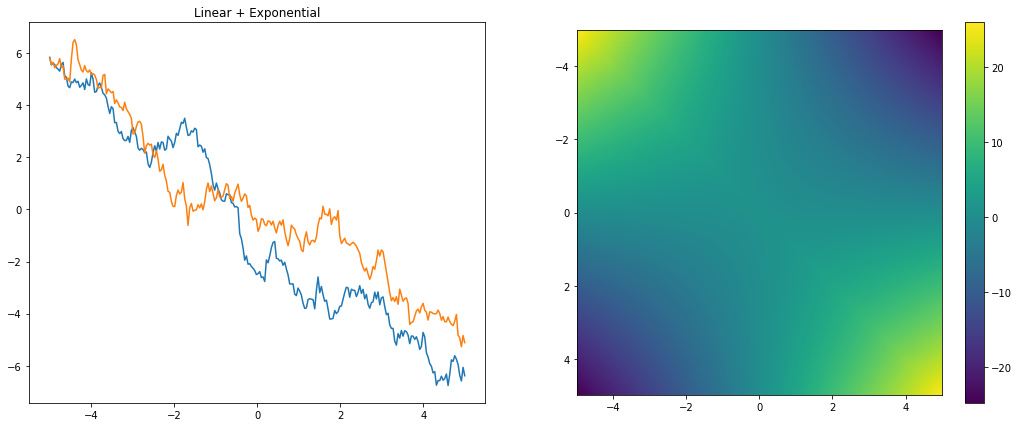

In [13]:
ks = [ # List of example kernels
    GPy.kern.RBF(1, lengthscale=1.),
    GPy.kern.RBF(1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.25, variance=2.),
    GPy.kern.Exponential(1),
    GPy.kern.Matern32(1),
    GPy.kern.Matern52(1),
    GPy.kern.StdPeriodic(1, period=2.),
    GPy.kern.Cosine(1),
    GPy.kern.Brownian(1),
    GPy.kern.Linear(1),
    GPy.kern.Bias(1),
    GPy.kern.White(1),
    GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1),
    GPy.kern.Linear(1) + GPy.kern.Exponential(1)
]
# The name of our kernels (for the legend)
kernel_name = ["RBF ls=1", "RBF ls=0.5", "RBF ls=0.25, var=2", "Exponential", "Matern 3/2", 
               "Matern 5/2", "Periodic", "Cosine", "Brownian", "Linear", "Bias", "White", "Periodic x RBF", "Linear + Exponential"]

# Our sample space
X = np.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

# Loop through our kernels
for i,k in enumerate(ks):
    # The mean function is set to 0
    mu = np.zeros((250)) # we have 250 sample inputs
    # Get the covariance matrix
    if i is not 11:
        C  = k.K(X,X)
    else: # We have to sample White noise kernel differently
        C = k.K(X)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    
    # Setup figure environment
    plt.figure(figsize=(18, 7))
    
    # Show samples on left hand side
    plt.subplot(121)
    for j in range(5 if i < 11 else 2): # Loop through samples
        plt.plot(X[:],Z[j,:])
        plt.title(kernel_name[i])
        
    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

These samples are from the Gaussian process prior made up of the covariance function and a zero mean. After GP regression, the fitted posterior can also be sampled in this manner, to get samples of the fitted function.

### Exercise 3

Can you identify the covariance function used to generate the following samples?

![exercise_3](https://github.com/wilocw/gpss18_resources/raw/master/lab/lab1_kernel_samples_example.png)

The answers:

> _(a) Gaussian / RBF_
>
> _(b) Linear * Cosine_
>
> _(c) Matern 3/2 + Bias_
>
> _(d) Exponential_
>
> _(e) Brownian * RBF_
>
> _(f) Periodic * Matern 5/2_

Generated using the following code:
```
f, axs = plt.subplots(2,3,figsize=(18,12))
X = np.linspace(0., 5., 1000)[:, None]
ks = [
    GPy.kern.RBF(1, lengthscale=0.25),
    GPy.kern.Cosine(1, lengthscale=0.1) * GPy.kern.Linear(1),
    GPy.kern.Bias(1) + GPy.kern.Matern32(1, lengthscale=0.5, variance=1),
    GPy.kern.Exponential(1, lengthscale=0.3),
    GPy.kern.RBF(1, lengthscale=0.5) * GPy.kern.Brownian(1),
    GPy.kern.Matern52(1, lengthscale=0.15) * GPy.kern.StdPeriodic(1)
]

labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

for i in range(2):
    for j in range(3):
        k = ks[i*3+j]
        Z = np.random.multivariate_normal(np.zeros((1000)), k.K(X, X), 2)
        for z in Z:
            axs[i,j].plot(X, z)
            axs[i,j].set_title(labels[ i*3+j])
            axs[i,j].tick_params(
                axis="both",
                which="both",
                bottom=False,
                left=False,
                labelleft=False,
                labelbottom=False
            )
            axs[i,j].axis("tight")
```

---

## 5. Gaussian Process Regression

We will now use our Gaussian process prior with some observed data to form a GP regression model. 

Suppose we have a data model for which we only have noisy observations, $y = f(x) + \epsilon$ at some small number of sample locations, $\mathbf{X}$. Here, we set up an example function

$$
    f(x) = -\cos(2\pi x) + \frac{1}{2}\sin(6\pi x)
$$
$$
    \mathbf{y} = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.01)
$$

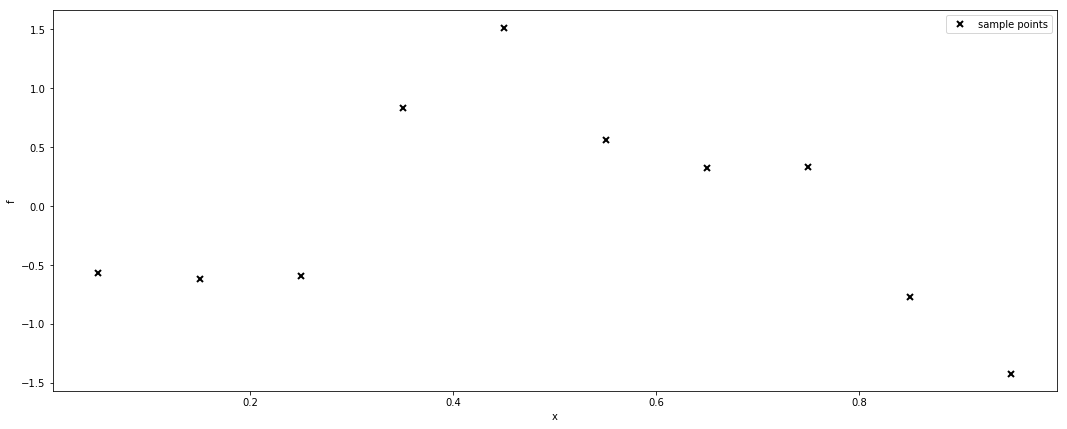

In [15]:
# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations 
X = np.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (10,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(18, 7))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

We will first apply Gaussian process using the exact equations.

A Gaussian process regression model using a Gaussian RBF covariance function can be defined first by setting up the kernel:

In [16]:
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")

And then combining it with the data to form a Gaussian process regression model, with $\mathbf{X}^*$ representing _any_ new inputs (imagine $\mathbf{f}^*$ approximates $f(\mathbf{X}^*)$):

$$
\left.\mathbf{f}^*\,\right|\,\mathbf{X}^*,\mathbf{X},\mathbf{y} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{C}\right),
$$

where $
\mathbf{m} = \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{y}$ and $\mathbf{C} = \mathbf{K}_{**} -  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{K}_{*x}^\text{T}
$ and covariance matrices are defined by evaluations of the kernel functions: $\mathbf{K}_{xx} = k(\mathbf{X}, \mathbf{X})$; $\mathbf{K}_{*x} = k(\mathbf{X}^*, \mathbf{X})$; and $\mathbf{K}_{**} = k(\mathbf{X}^*,\mathbf{X}^*)$.

In [17]:
# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X,X) + 1 * np.eye(10)

# Covariance between training and test points
Kxs = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew,Xnew)

# The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
mean = Kxs @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Kxs @ np.linalg.inv(Kxx) @ Kxs.T

Here we define a quick plotting utility function for our GP fits. There are a number of plotting options available in GPy, but we will use the below method, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [18]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

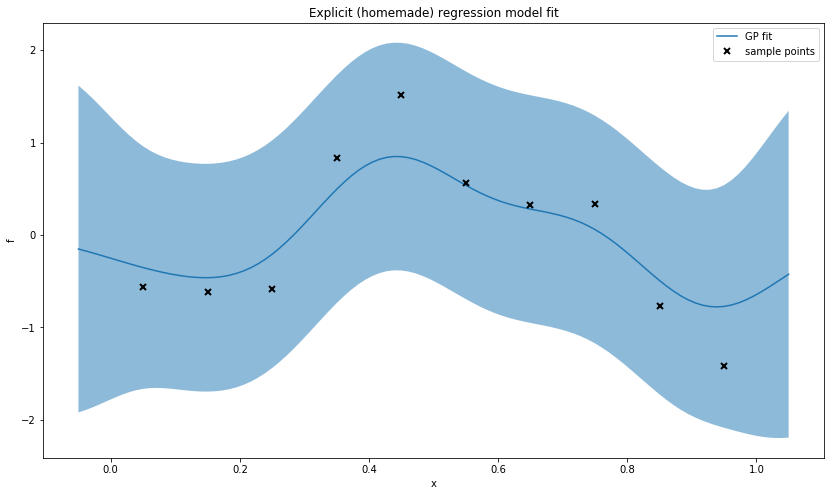

In [19]:
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("Explicit (homemade) regression model fit");

We can also save effort and time by to do Gaussian process regression using `GPy`, by creating a GP regression model with sample points $(\mathbf{X}, \mathbf{Y})$ and the Gaussian RBF kernel:

In [20]:
m = GPy.models.GPRegression(X, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


We can use GPy's regression and prediction tools, which _should_ give the same result as our basic implementation:

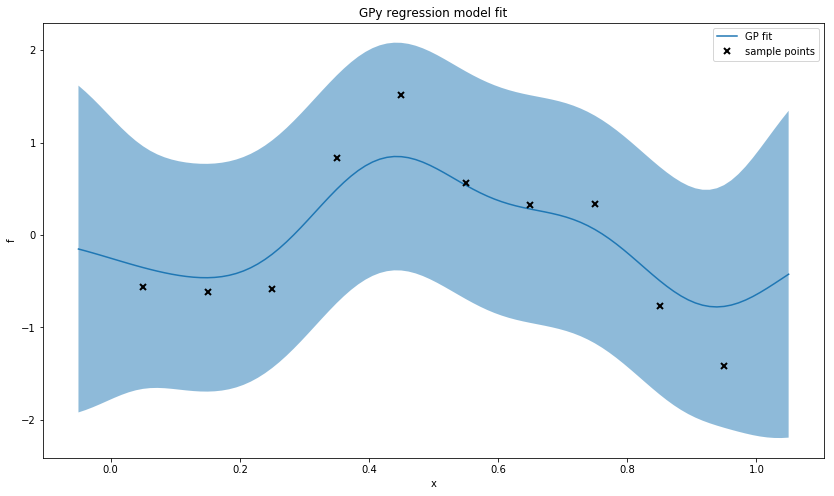

In [21]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

It can be clearly seen that this *is* the same fit as our above model. However, using GPy gives flexibility and ease of use for extending the capabilities of the fitting, including use of different kernels, optimising parameters and solving more complicated problems, including classification. We also don't need to write explicit equations and manually creating covariances matrices.

### Exercise 4

(a) What do you think of this initial fit? Does the prior given by the GP seem to be adapted?

> _It's clear that the observatinos are captured in the confidence interval, but the fit is not particularly good. The parameters used may not be the best they can be to minimise the loss of the fit._

(b) The parameters of the model can be editted much like those of the kernel. For example, 
```
m.Gaussian_noise = 0.1
```
or
```
m.rbf.variance = 2.0
```
Change the values of the parameters to try and obtain a better fit of the GP. You can recalculate the updated mean and covariance after changing the values by calling `m.predict_noiseless` as above.

*Note: changing the original kernel `k` will also affect the model parameters due to how Python connects objects, but this is not a reliable way of setting the parameters, so you should adjust the kernel parameters via the model `m` as described*

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


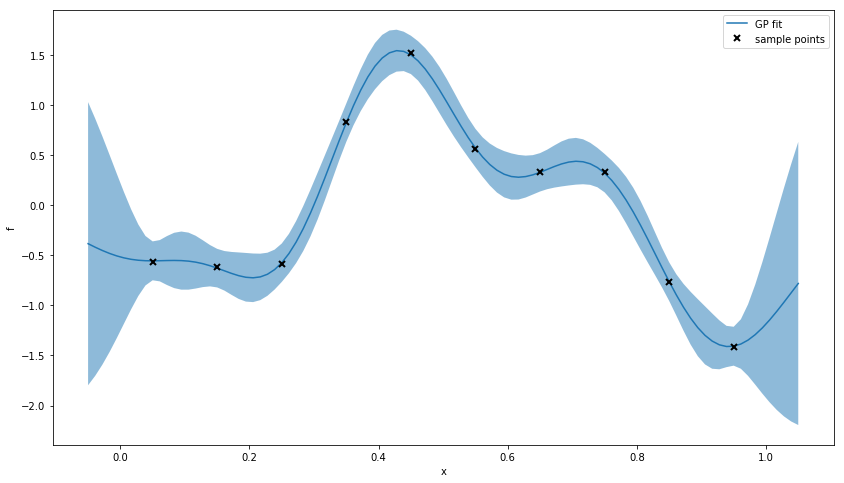

In [22]:
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

# Preview the regression model
m

(c) Given that we can obtain the mean and covariance of the GP fit, we can also sample the GP posterior as a multivariate Gaussian process. This can be done as in Section 4, where we sampled the priors as defined by the kernels, i.e. with `np.random.multivariate_normal`. Obtain 10 samples from the GP posterior and plot them alongside the data. Try to simulate noisy measurements using `m.predict` (rather than `m.predict_noiseless`).

*Remember to get the full covariance matrix, using `full_cov=True`, and note that to make the mean vector 1-D (for sampling a multivariate normal), you need `np.random.multivariate_normal(mean[:,0], Cov)`)*

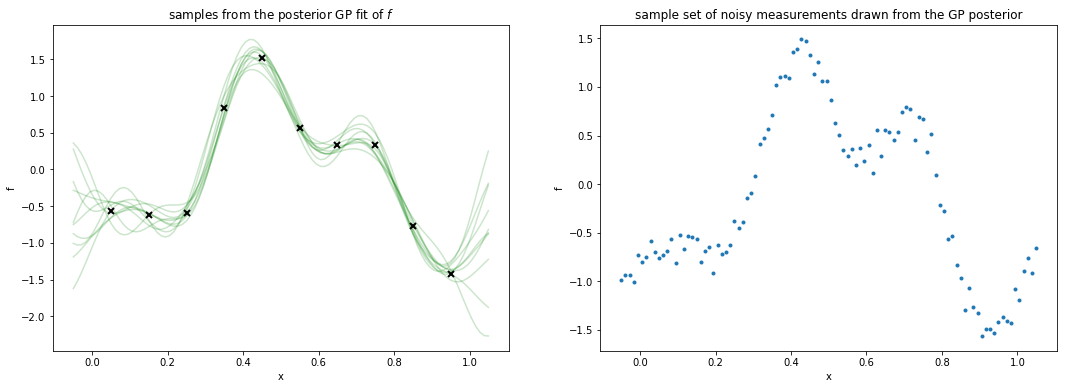

In [23]:
#[answer]
plt.figure(figsize=(18, 6))

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 10)
plt.subplot(121)
for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2)
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("x"), plt.ylabel("f"), plt.title("samples from the posterior GP fit of $f$")    

mean, Cov = m.predict(Xnew, full_cov=True)
z  = np.random.multivariate_normal(mean[:,0], Cov)
plt.subplot(122)
plt.plot(Xnew, z, ".")
plt.xlabel("x"), plt.ylabel("f"), plt.title("sample set of noisy measurements drawn from the GP posterior");

---

## 6. Covariance Function Parameter Estimation

As discussed in the lectures, the values of kernel parameters can be estimated by maximising the likelihood of the observations. This is useful to optimise our estimate of the underlying function, without eye-balling parameters to get a good fit.

In `GPy`, the `model` objects such as `GPRegression`, have parameter optimisation functionality. We can call this as following:

In [24]:
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,0.9264364639075393,+ve,
rbf.lengthscale,0.12490906403526585,+ve,
Gaussian_noise.variance,1.952669113858086e-09,+ve,


We can see the selected parameters in the model table above. The regression fit with the optimised parameters can be plotted:

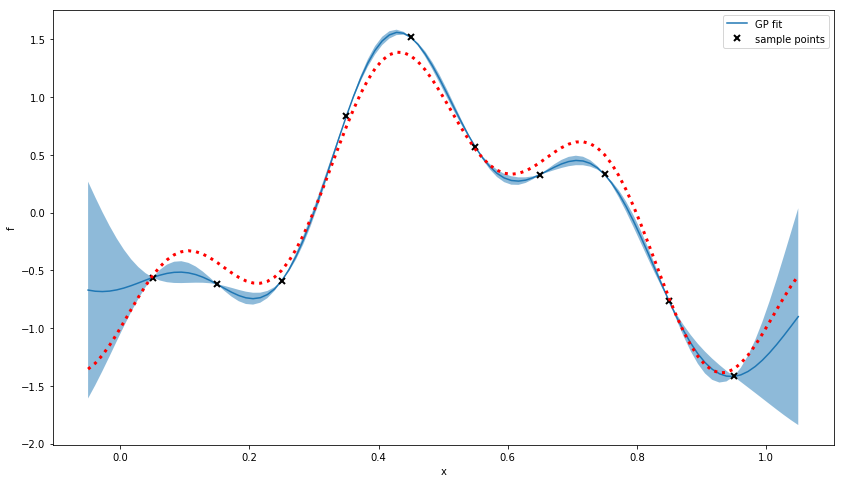

In [25]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Setup the figure environment
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)

### Parameter constraints

We can see in the above model that the regression model is fit to the data, as the optimiser has minimised the noise effect in the model, `Gaussian_noise.variance`$ = 4.804\times10^{-8}$. If we *know*, or can reasonably approximate, the variance of the observation noise $\epsilon$, we can fix this parameter for the optimiser, using `fix`, which in the case of the above is $0.01$. We can also limit the values that the parameters take by adding constraints. For example, the variance and lengthscale can only be positive, so calling `constrain_positive`, we can enforce this (note that this is the default constraint for GP regression anyway).

In [26]:
# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at 0.01 
m.Gaussian_noise.variance = 0.01 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
m

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.8341912602146944,+ve,
rbf.lengthscale,0.11993052527773222,+ve,
Gaussian_noise.variance,0.01,fixed +ve,


We can see our constraints in the corresponding column in the above table, where "`+ve`" means we are constrained to positive values, and `fixed` means the optimiser will not try and optimise this parameter. We can see here that the variance of the noise in the model is unchanged by the optimiser. Looking at the resulting plot, we can see that we have a much more reasonable confidence in our estimate, and that the true function is hard to distinguish from samples drawn from our fit, indicating that we have reasonable approximation of the true function given noisy observations.

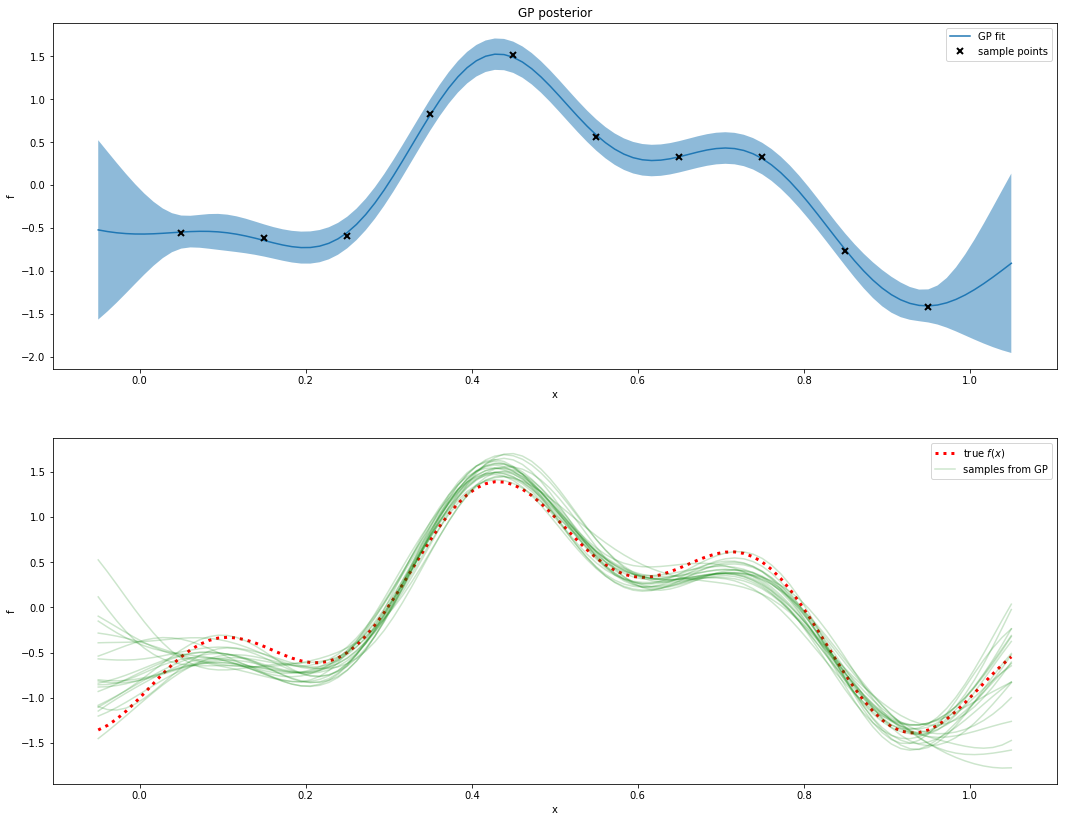

In [27]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Setup our figure environment
plt.figure(figsize=(18, 14))

# The top plot shows our mean regression fit and 95% confidence intervals 
plt.subplot(211)
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GP posterior")
plt.subplot(212)

plt.plot(Xnew, f(Xnew),"r:", lw=3)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 20)
for z in Z:
    plt.plot(Xnew,z, "g-", alpha=0.2)
    
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["true $f(x)$", "samples from GP"]);

Using the prior knowledge of the noise in the data has given us a reasonably good approximation of the true function. The samples from the GP demonstrate provide fits to the observed data and roughly follow the shape of the true function $f$, particularly in the range for which we have samples.

### Exercise 5

The function we used is a sum of sinusoids, and therefore has inherent periodicity. However, we only have samples for a single period, so this is not directly seen in the domain of $[0, 1]$.

(a) Try predicting the function on the range of $[0, 2]$ instead (`Xnew = np.linspace(0., 2., 100)[:,None]`), and compare the fitted GP posterior with the true function $f$.

*Note, you shouldn't need to retrain the model or adjust the hyperparameters.*

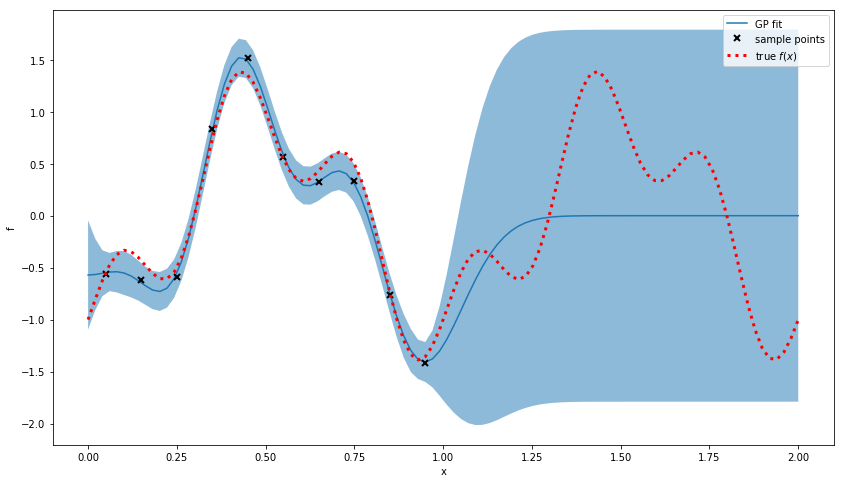

In [28]:
Xnew = np.linspace(0., 2., 100)[:, None]
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)
plt.legend(labels=["GP fit", "sample points", "true $f(x)$"])

(b) Comment on the fit of the GP, and the uncertainty in regions where we have no observations. Is the GP still a good fit? How might we produce a better fit, for example, if we knew $f(x)$ had a periodic nature?

> _The prediction becomes useless in the areas where we are extrapolating, which makes some degree of sense. However, since the function is sinusoidal, we can see there is some periodicity that we may be able to exploit in our GP fit_ 

---

## 7. Real World Example

We'll consider now a classic real world example using atmospheric CO$_2$ observations from the Mauna Loa Observatory, Hawaii. The dataset is a good demonstration of the predictive power of Gaussian processes, and we will use it to show how we can encode our prior beliefs to combine kernels.

First, we need to download the dataset, which can be done through a utility provided by `GPy`. 

In [29]:
GPy.util.datasets.authorize_download = lambda x: True # This gives GPy permission to download the dataset

# Download the data, cache it locally and pass to variable `data`
data = GPy.util.datasets.mauna_loa(refresh_data=False)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])

Using cached version of the data set, to use latest version set refresh_data to True
Most recent data observation from month  6.0  in year  2018.0

Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


#### Training and testing

The dataset provided is separated automatically into a training and test set. We will use the training set to fit our GP and use the test data to visualise the predictive power of our GP fit.

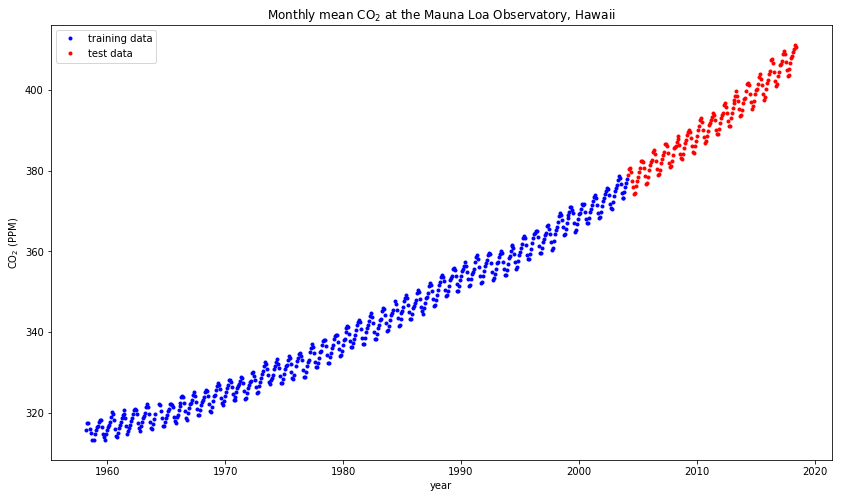

In [30]:
# Training data (X = input, Y = observation)
X, Y = data['X'], data['Y']

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = data['Xtest'], data['Ytest']

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

**You may want to subsample the data to save time during the labs**

Run the following to reduce the datasize by only using every other training point:

In [31]:
X = X[::2, :]
Y = Y[::2, :]

### Naive GP regression

First, we will try to fit a basic RBF to our data, as we have used in previous examples

In [32]:
k = GPy.kern.RBF(1, name="rbf")

m = GPy.models.GPRegression(X, Y, k)
m.optimize()

m

GP_regression.,value,constraints,priors
rbf.variance,121405.89545481613,+ve,
rbf.lengthscale,101.48850413493186,+ve,
Gaussian_noise.variance,4.577871856859133,+ve,


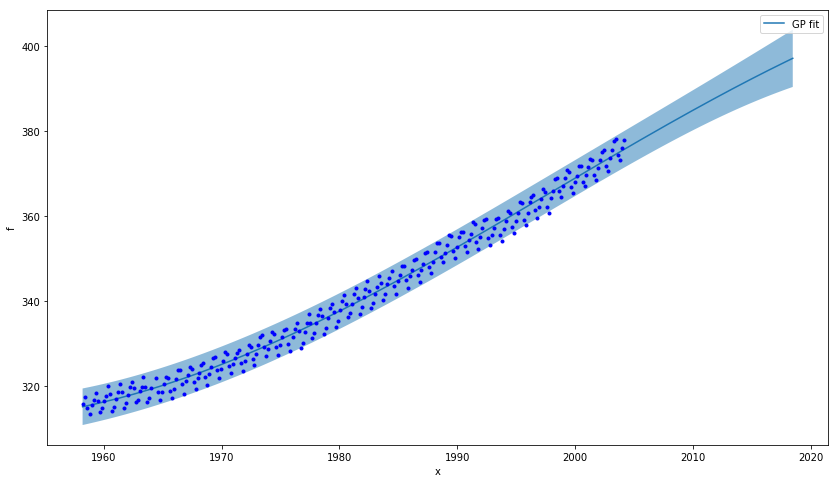

In [33]:
Xnew = np.vstack([X, Xtest])

mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

It is possible to make the model fit the data near perfectly by minimising the variance of the Gaussian noise in the likelihood and fixing the kernel variance.

In [34]:
# Effectively remove noise parameter (needs to be >0, so select value that is very low)
m.Gaussian_noise.variance = 0.00001
m.Gaussian_noise.variance.fix()

# We will fix the variance as well, so that only the lengthscale is optimised
m.rbf.variance = 10.
m.rbf.variance.fix()

# This should minimize the lengthscale to fit closely to the training points
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,10.0,+ve fixed,
rbf.lengthscale,9.582503651259924e-105,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


**But** this has no predictive power, and we have really just overfitted to the training data

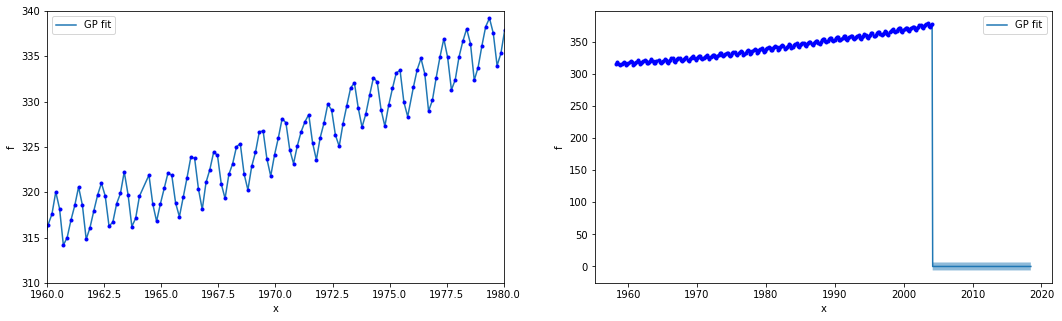

In [35]:
mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(18, 5))

# The left plot shows the GP fit to a subsample of our training set
plt.subplot(121)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");
plt.gca().set_xlim([1960,1980]), plt.gca().set_ylim([310, 340])

# The right plot shows that the GP has no predictive power and reverts to 0
plt.subplot(122)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

### GP Regression with combined covariance functions

Taking a look at the training data, we can see a number of features that occur in the data. There is a clear periodic trend that is yearly, and an approximately linear trend. We can use this prior information in our choice of kernel to give some meaning to the GP fit.

First, we will look at the linear trend. It should be obvious that the overall trend (ignoring the periodicity) can be described approxiximately by $f(x) \approx a + bx$. To embed this as a covariance function, we can use the `Bias` and `Linear` covariance functions, which add a constant and linear trend respectively.

### Exercise 6

(a) Create `Bias` and `Linear` kernels with reasonable estimates of the parameters that represent the trend?

In [36]:
# [answers]
k_B = GPy.kern.Bias(1, variance=360)
k_L = GPy.kern.Linear(1, variances=[1.])

(b) Create a GP regression model using the kernels to fit the data. Comment on good is the fit and the predictive power of the model? 

GP_regression.,value,constraints,priors
sum.bias.variance,360.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


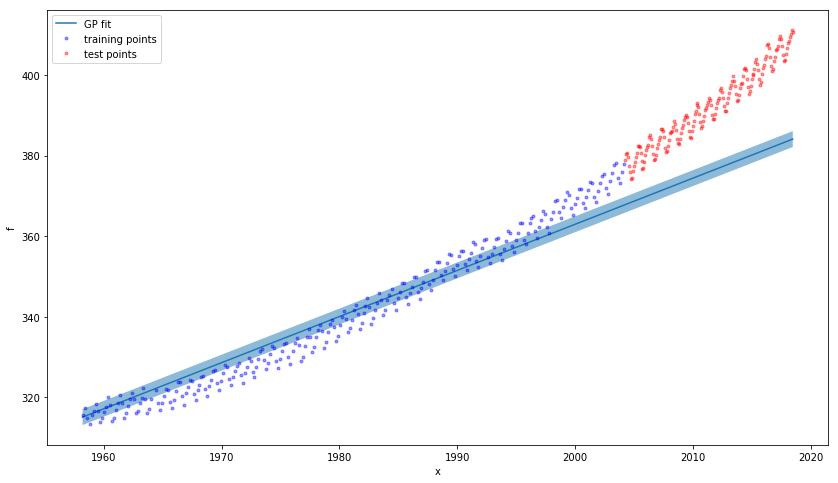

In [37]:
# [answers]
m = GPy.models.GPRegression(X, Y, k_B + k_L)

mean, Cov = m.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

m

> _While we have captured a reasonable estimate of the trend *were it linear*, it's clear that there is some non-linearity in the trend, and so a linear regression model is insufficient  on its own._

### Periodicity

It's there is a seasonal trend over the year, and that a simple linear fit cannot capture this information. However, we can add this using our choice of kernel by adding a `StdPeriodic` kernel to our regression model. It's evident to the data that the period is yearly, so a period of $\omega=1$ is a sensible choice for our initial parameter:

GP_regression.,value,constraints,priors
sum.bias.variance,10000.164778045335,+ve,
sum.linear.variances,2.0959322439298416,+ve,
sum.std_periodic.variance,14.662314861217865,+ve,
sum.std_periodic.period,0.999433524980492,+ve,
sum.std_periodic.lengthscale,1.0072243496100788,+ve,
Gaussian_noise.variance,4.344285267878375,+ve,


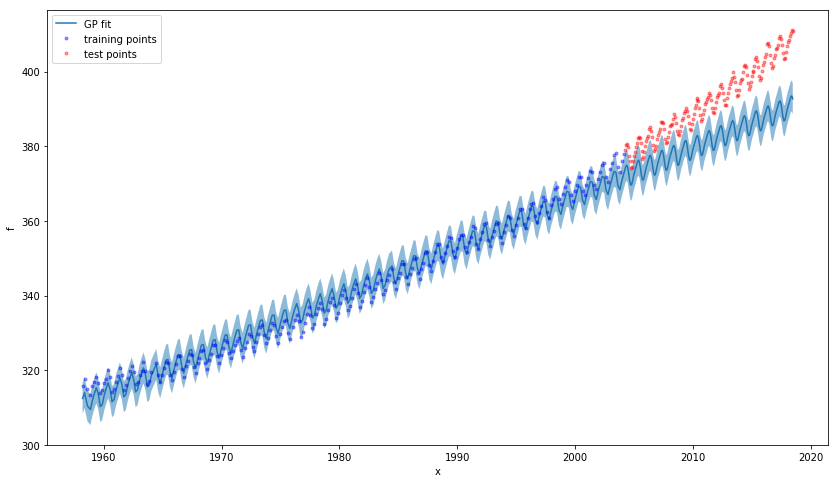

In [38]:
ks = [ # Our kernels
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1)     # Periodicity
]

# Create a regression model with an additive kernel (bias + linear + periodic)
m = GPy.models.GPRegression(X, Y, ks[0] + ks[1] + ks[2])

# Optimise hyperparameters to maximise likelihood
m.optimize()

# Predict the value of CO2 using our GP fit
mean, Cov = m.predict(Xnew)

# Set up plotting
plt.figure(figsize=(14,8))

# Plot GP fit
plot_gp(Xnew, mean, Cov)
# Show our training and test points
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4)
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])

# Preview the parameters of our model
m

From the plot we can see that while we have maintained the periodicity in our prediction, there is some deviation in the amplitude of each period. Likewise, the data is not strictly linear. We can embed model these non-linearities and deviations by adding an `Exponential` kernel. First, in the summative kernel, but also by multiplying a Gaussian RBF by the periodic kernel. For some intiution on how this allows for deviation of the periodicity, see the corresponding sample plot in Section 4.

Note that the `Exponential` kernel describes an exponential decay in covariance with distance between points, and does **not** model an exponential trend in the overall data. The `RBF` kernel describes a smoother (Gaussian) decay, which may be a better model for changes in the periodic signal.

In [39]:
ks = [ # Our kernels
    GPy.kern.Exponential(1),              # Non-linearity in overall trend
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1.),   # Periodicity (short term trend)
    GPy.kern.RBF(1)                       # Amplitude modulator (long term trend)
]

# Composite kernel: exponential + bias + linear + (periodic * rbf)
k = ks[0] + ks[1] + ks[2] + ks[3]*ks[4]
k

sum.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,1.0,+ve,
bias.variance,10000.0,+ve,
linear.variances,1.0,+ve,
mul.std_periodic.variance,1.0,+ve,
mul.std_periodic.period,1.0,+ve,
mul.std_periodic.lengthscale,1.0,+ve,
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,1.0,+ve,


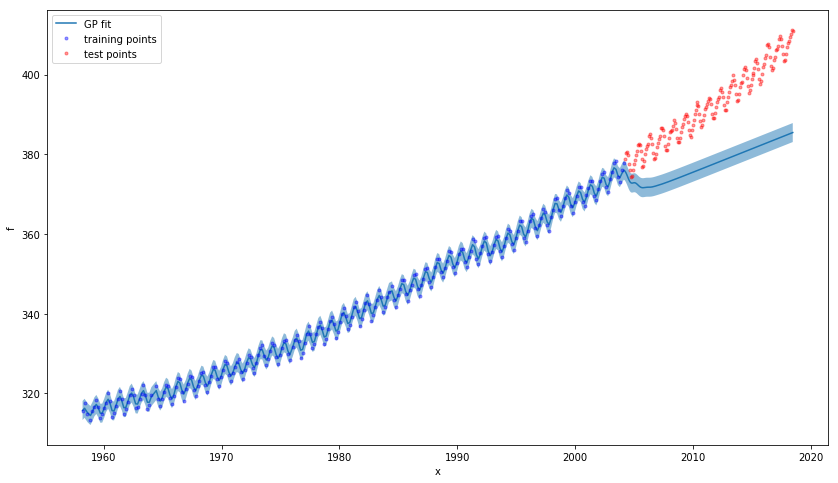

In [40]:
# Create our GP regression model with the composite kernel
m = GPy.models.GPRegression(X, Y, k)

# Predict the CO2 at the training and test locations
mean, Cov = m.predict(Xnew)

# Setup figure 
plt.figure(figsize=(14,8))

# Plot the GP fit and training points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);

# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"]);

We can see that with even with our initial (mostly default) parameter choices, the GP fit to the training data is representative of the trends we are observing. However, the prediction of the test data is relatively poor (though we still have an upward trend). The obvious step now is to optimise our kernel parameters.

Optimisation of the GP in itself is imperfect, often because the likelihood we are maximising can be multimodal, or flat, and so it can get stuck in local-maxima. It is always important to sanity-check the GP fit when optimising the parameters, to mitigate problems that could occur as a result (such as the minimised noise example we saw earlier). One of the ways to avoid the problem of local maxima is to reinitialise the optimiser with different starting locations, and take the maximum of these outputs. This is possible in `GPy` using `optimize_restarts(n)`, which will optimise the parameters $n$ times and take the best estimate.

Optimization restart 1/5, f = 149.58855703339006
Optimization restart 2/5, f = 516.9094197867861
Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 149.6112534172583
Optimization restart 5/5, f = 170.28656729284913


GP_regression.,value,constraints,priors
sum.Exponential.variance,12.212202218455085,+ve,
sum.Exponential.lengthscale,32.06765840797962,+ve,
sum.bias.variance,0.7071357582759953,+ve,
sum.linear.variances,0.04468020314505923,+ve,
sum.mul.std_periodic.variance,86.51039212727089,+ve,
sum.mul.std_periodic.period,0.9991899588059091,+ve,
sum.mul.std_periodic.lengthscale,3.747580004751326,+ve,
sum.mul.rbf.variance,106.86753772415837,+ve,
sum.mul.rbf.lengthscale,142.6648419539512,+ve,
Gaussian_noise.variance,1.735346673074399e-16,+ve,


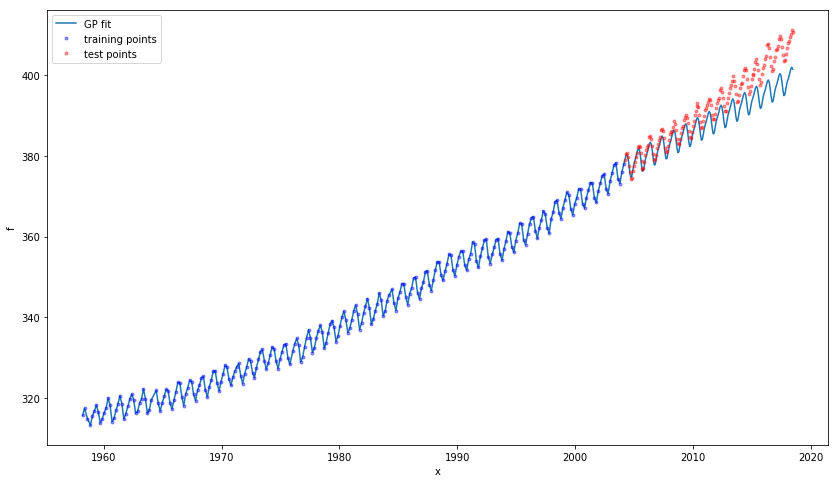

In [41]:
# Optimise hyperparameters 5 times to get a good estimate 
m.optimize_restarts(5, robust=True) # We could do this more times, but it can be quite time consuming

# Get the moments of our model fit
mean, Cov = m.predict(Xnew)

# Set up plot environment
plt.figure(figsize=(14,8))

# Plot our optimised GP and training/test points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])
# Preview model parameters
m

We can see from the output of the optimiser that there are a number of different minima in the negative log-likelihood (corresponding to maxima in the likelihood), implying that there are several modes. However, it's possible to get a good fit of the function with a GP with great predictive power. You might try allowing the optimiser to run for more iterations when you have more time.

We can also look at the effects of each kernel on the GP model, which will show the features that it represents in the fit. For example, we expect the `Bias` to capture the offset, and the `Exponential` kernel to extract most of the non-linearity (that's not explained by the periodicity). We can view the effects of each of the components and the combination of them to see how they deconstruct the training data. This shows what features are being learned by which kernel.

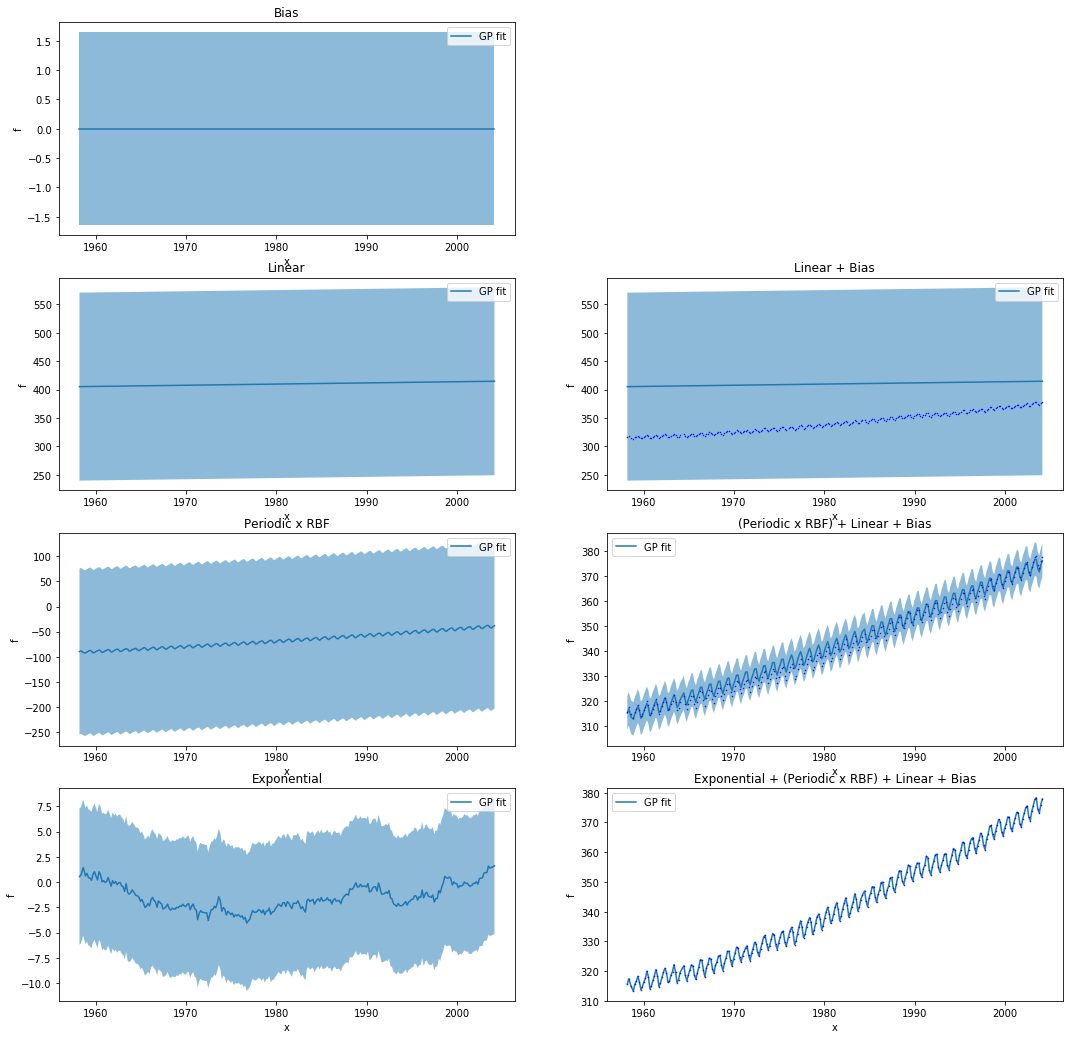

In [42]:
# Setup figure environment (4x2 grid)
plt.figure(figsize=(18,18))

# Show Bias kernel effect
plt.subplot(421)
mean, Cov = m.predict_noiseless(X, kern=m.sum.bias)
plot_gp(X, mean, Cov)
plt.title("Bias")

# Show Linear kernel effect
plt.subplot(423)
mean, Cov = m.predict_noiseless(X, kern=m.sum.linear)
plot_gp(X, mean, Cov)
plt.title("Linear")

# Show combination of Bias and Linear kernels
plt.subplot(424)
mean, Cov = m.predict_noiseless(X, kern=m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Linear + Bias")

# Show modulated Periodic x RBF kernel
plt.subplot(425)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul)
plot_gp(X, mean, Cov)
plt.title("Periodic x RBF")

# Show combination of Periodic, Bias and Linear kernels
plt.subplot(426)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul + m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("(Periodic x RBF) + Linear + Bias")

# Show Exponential kernel effect
plt.subplot(427)
mean, Cov = m.predict_noiseless(X, kern=m.sum.Exponential)
plot_gp(X, mean, Cov)
plt.title("Exponential")

# Show combination of Periodic, Bias, Linear and Exponential kernel (this is our full GP fit !)
plt.subplot(428)
mean, Cov = m.predict_noiseless(X, kern=m.sum.Exponential + m.sum.mul + m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Exponential + (Periodic x RBF) + Linear + Bias");

It's clear that while our final fit is very good, some of the kernel effects are not as clear cut as we expected. For example, much of the upward trend is captured by the periodic combination, likely due to its ability to vary non-linearly. However, we can see that, for example, the `Exponential` kernel has a clear purpose in adjusting the GP fit to the data.

### Exercise 7

What improvements might be made to the GP model, for example in terms  combinations of kernels and parameters, to get a better fit, especially for the prediction of our testing data?

> _How clear the differing effects of the kernels are is dependent on the random seed, and the number of optimisation restarts of the hyperparameters. However something that can be observed is that trying to embed the linear trend in the covariance function with a nonlinear periodic function is largely redundant as the periodic*rbf kernel is clearly capturing most of the upward trend. We might play around with smoother non-linear kernels, for example adding a higher order Matern than exponential (3/2 or 5/2). We can also make use of kernels not shown in this lab, such as the periodic Matern kernels._
>
> _Another option is to embed our linear trend in the *mean function* of our GP prior. While this is not especially common in machine learning, if we have reliable prior assumptions of the model, we can embed this explicitly. Putting a prior over the parameters of the linear mean function would keep the Bayesian approach to learning the model, but would allow us to fit periodicity to the data independent(ish) of the linear mapping._

Optimization restart 1/20, f = 372.1952776457107
Optimization restart 2/20, f = 153.10899566835997
Optimization restart 3/20, f = 517.0218051093676
Optimization restart 4/20, f = 259.1527780498224
Optimization restart 5/20, f = 133.199558583779
Optimization restart 6/20, f = 513.9890706549099
Optimization restart 7/20, f = 156.80349423062341
Optimization restart 8/20, f = 509.13913049659453
Optimization restart 9/20, f = 142.84201565608282
Optimization restart 10/20, f = 154.64329278804388
Optimization restart 11/20, f = 508.821367555633
Optimization restart 12/20, f = 149.35518076910896
Optimization restart 13/20, f = 615.8832667279473
Optimization restart 14/20, f = 148.42874691006364
Optimization restart 15/20, f = 624.6664844879401
Optimization restart 16/20, f = 626.177975448103
Optimization restart 17/20, f = 621.9009661579539
Optimization restart 18/20, f = 4117908.5257488317
Optimization restart 19/20, f = 225.06261675782264
Optimization restart 20/20, f = 514.599607115377


GP_regression.,value,constraints,priors
mapping.linmap.A,[1.29531749],+ve,"Ga(4.5, 1.5)"
mapping.constmap.C,-2222.0333401375633,,"N(-2e+03, 1e+03)"
sum.Exponential.variance,7.623680224574812,+ve,
sum.Exponential.lengthscale,37.248868370768825,+ve,
sum.mul.std_periodic.variance,14.662787068702436,+ve,
sum.mul.std_periodic.period,0.9995618654481333,+ve,
sum.mul.std_periodic.lengthscale,0.7110484773093899,+ve,
sum.mul.rbf.variance,0.5051701795907066,+ve,
sum.mul.rbf.lengthscale,216.1720283428598,+ve,
Gaussian_noise.variance,0.028588987148727155,+ve,


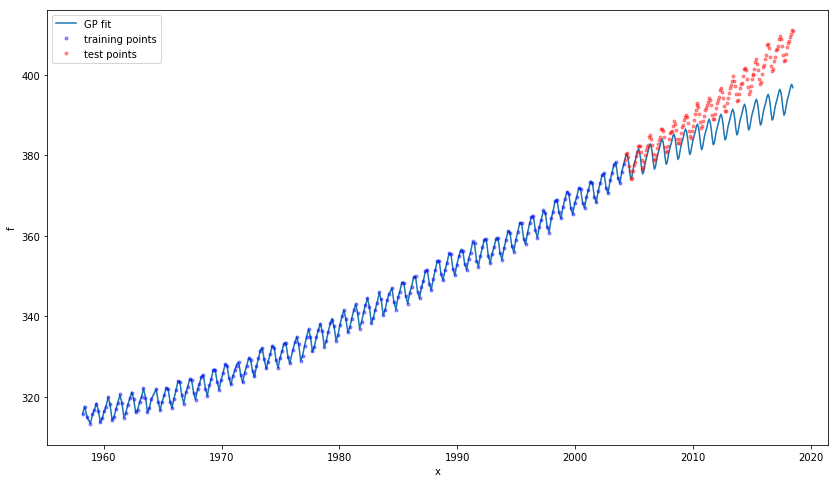

In [43]:
# [example answer]
mean_func = GPy.mappings.Additive(GPy.mappings.Linear(1,1), GPy.mappings.Constant(1,1))
cov_func  = GPy.kern.Exponential(1) + GPy.kern.StdPeriodic(1, period=1.)*GPy.kern.RBF(1) # equivalent to k

m = GPy.models.GPRegression(X, Y, mean_function=mean_func, kernel=cov_func)

m.mapping.linmap.set_prior(GPy.priors.Gamma.from_EV(E=3, V=2))
m.mapping.constmap.set_prior(GPy.priors.Gaussian(mu=-2000., sigma=1000.))

m.Gaussian_noise.variance = 10.

m.optimize_restarts(20, robust=True)

# Get the moments of our model fit
mean, Cov = m.predict(Xnew)
# Set up plot environment
plt.figure(figsize=(14,8))
# Plot our optimised GP and training/test points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])
# Preview model parameters
m

## 8. Multiple Inputs

Typically, we will have data that is more than one-dimensional. Gaussian processes regression is scalable in dimension, and everything used above can be used with multiple inputs. The following problem is reasonably straight-forward, a simple extension of the regression problem we've used to 2-dimensional input.

Consider the toy example:
$$
    f = (x_1, x_2) \mapsto \sin(x_1)\sin(x_2)
$$
$$
    y = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

Now, our input space is made up of two coordinates, $(x_1, x_2)$. Suppose we have some random noisy observations of the function, which are 1-dimensional in nature:

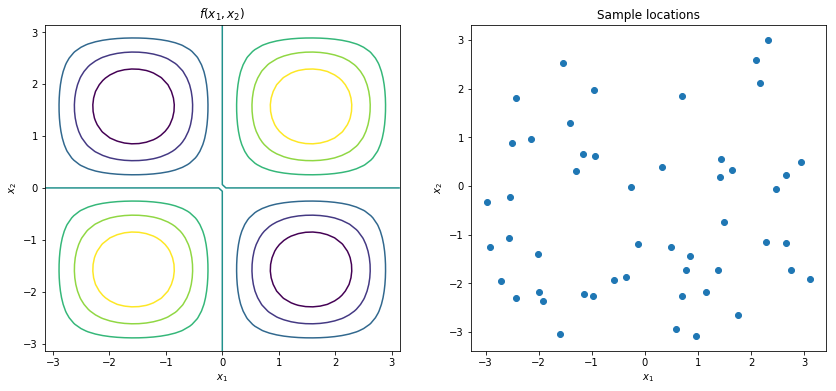

In [44]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi,Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("$f(x_1,x_2)$")

plt.subplot(122)
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o')
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Sample locations");  

Our observations then are simply our sample locations propagated through $f$ with some Gaussian noise

In [45]:
Y2 = np.array([f(x1,x2) for (x1,x2) in zip(X2[:,0], X2[:,1])])[:,None] + 0.05 * np.random.randn(X2.shape[0], 1)

We can fit a Gaussian process over the observations by selecting a 2-D kernel. For example, the `RBF` kernel has a 2-D (really N-D) form, so we can use this as our kernel choice. Here we need to set both the `input_dim` to `2`, and specify the dimensions of the data we want the kernel to act over. In this case, it is the first 2 (of 2) dimensions, which in Python are indexed by `0` and `1`.

GP_regression.,value,constraints,priors
rbf.variance,0.24000063213032985,+ve,
rbf.lengthscale,1.3792620622890857,+ve,
Gaussian_noise.variance,0.05,+ve fixed,


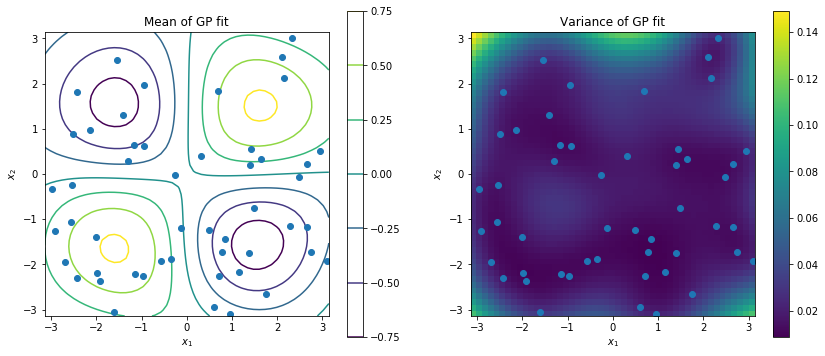

In [46]:
# Create a 2-D RBF kernel active over both input dimensions
k = GPy.kern.RBF(2, active_dims=[0,1])

# Create a GP Regression model with the sample locations and observations using the RBF kernel
m = GPy.models.GPRegression(X2, Y2, k)

# Fix the Gaussian noise variance, which we know
m.Gaussian_noise.variance = 0.05 
m.Gaussian_noise.variance.fix()

# Optimise the kernel parameters
m.optimize()

# We need to augument our test space to be a list of coordinates for input to the GP
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean and covariance of the GP fit at the test locations
mean2, Cov2 = m.predict_noiseless(Xnew2, full_cov=False)

# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)    
# Plot variance surface
plt.pcolor(Xi, Xj, Cov2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

# Preview GP model parameters
m

We can see here that the fit with the GP is generally good (this is quite a simple example, after all), and that functionally, the setup is almost identical to the 1-D case using `GPy`. We can also observe from the variance surface that we have the most uncertainty where there are no samples, which matches our expectations and the observation of the power of GPs in 1-D.

Notice that in the model preview, we only have a single lengthscale that is based on both dimensions. This is because by default, the RBF kernel is isotropic, which in our case is fine. However, in reality, it is often desirable to have different parameters corresponding to different dimensions. There are two approaches to doing this in `GPy`. The first is to enable different anisotropy within the kernel itself, by using the `ARD` keyword, e.g.
```
k = GPy.kern.RBF(2, ARD=True)
```

Alternatively, we can use kernel composition to create two kernels acting seperately on different dimensions. An alternative construction of the anisotropic RBF is to construct a kernel from two 1-D `RBF` kernels active on $x_1$ and $x_2$ respectively:
```
k = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.RBF(1, active_dims=[1])
```

We can also use this construction to allow for different covariance assumptions in different dimensions. In the following example, we use an RBF to model $x_1$ and a Matérn 3/2 kernel for $x_2$:
```
k = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.Matern32(1, active_dims=[1])
```

GP_regression.,value,constraints,priors
mul.rbf.variance,0.4651011220448157,+ve,
mul.rbf.lengthscale,1.3518101523038828,+ve,
mul.Mat32.variance,0.4651011220448156,+ve,
mul.Mat32.lengthscale,1.673752561299822,+ve,
Gaussian_noise.variance,0.05,+ve fixed,


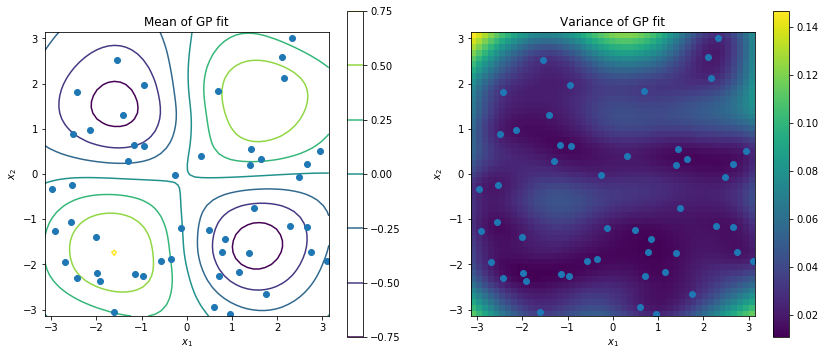

In [47]:
# Construct a 2-D kernel with two 1-D kernels: RBF and Matern32
k = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.Matern32(1, active_dims=[1])

# Create a GP regression model with our 2-D composite kernel
m = GPy.models.GPRegression(X2, Y2, k)

# Fix the Gaussian noise variance 
m.Gaussian_noise.variance = 0.05 
m.Gaussian_noise.variance.fix()

# Optimise the kernel parameters
m.optimize()

# Change our input grid to list of coordinates
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T

# Predict the mean and covariance function
mean2, Cov2 = m.predict_noiseless(Xnew2, full_cov=False)

# Setup figure environment
plt.figure(figsize=(14, 6))

# Plot mean on left
plt.subplot(121)      

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
# Plot sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()
           
# Show variance on right
plt.subplot(122)

# Plot variance surface
plt.pcolor(Xi, Xj, Cov2.reshape(Xi.shape))
# Plot sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

# Preview model parameters
m

---

## Footnote

Using Gaussian processes for machine learning gives you a powerful tool for learning latent functions in a Bayesian fashion, especially with a low number of observations. However, full GP regression can be quite time consuming, given it scales $\mathscr{O}(n^3)$ with the number of training points, $n$. There are methods for dealing with this: for example, sparse approximation or representing the regression problem as a state-space model. Each of these comes with their own assumptions and drawbacks. In tomorrow's session, there will be a lecture on computational efficiency in GPs and the next lab will have examples of some of these approaches.

When using GPs in a computational setting, there are a wide range of tools that can be used depending on your preference of programming language and libraries. `GPy`, the library we use in these labs, is a well established Python library that was developed here at the University of Sheffield, and is maintained by members here and at Amazon Research Cambridge. Some other libraries that are commonly used for Gaussian processes include:

| Name     | Language | Comments |
|---------|-----------|----------|
| `GPy`     | Python | The most popular GP library on GitHub (by stars)  |
| `gpml`    | MATLAB | Examples and code used in Rasmussen & Williams GPML book |
| `GPstuff` | MATLAB, Octave, R | A MATLAB library with a wide arrange of inference methods, including HMC |
| `GPFlow`  | Python | GP library built on `TensorFlow`, similar notation to `GPy` |
| `gpytorch` | Python | GP library built on `pytorch` (still in alpha) |
| `GaussianProcesses.jl` | Julia | GP library utilising Julia's fast JIT compilation | 
| `Stan`    | R, Python, others | Probabilistic programming using MCMC that can be easily be used to model GPs |